In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### TODO:
- group by fleets and measure on a fleet level
- group by addresses first and p_lat, p_lng second by choosing a radius to cluster p_lat, p_lng into groups
- invistigate phone calls, and reasons
- `do we need to recalc avg and median for last 3 months??`

# 1. Prepare Data

In [46]:
tasks = pd.read_csv('task_data.csv', index_col=0)
tasks

,created_at,mp_Task_nr,handover_time_seconds,o2a_time_seconds,p2a_time_seconds,phone_calls,dst_address_code,fleets,f0_,p_lat,...,median_handover_last_3_months,better_avg ?,diff,should_skip,why ?,is_parking_accurate (manual field),time in dubai,hour,day,is_weekend
id_task,,,,,,,,,,,,,,,,,,,,,
60148579,2025-03-13 07:15:10.000000 UTC,FF3DNN5CYLLE1OA,248,1659,734,3,addr::noon_customer::ae::1f7e4021508ae268f1730...,"SF_Downtown,QS_Businessbay,Businessbay","commercial_area,commercial_area,commercial_area",25.200012,...,208.0,False,-40.0,NaN,NaN,NaN,NaN,0.0,30.0,True
60392524,2025-03-15 15:17:21.000000 UTC,FF3FNNY2QF7CC9A,139,1978,1121,4,addr::noon_customer::ae::c297aff6ed4c598d69639...,"SF_Downtown,Businessbay","address_details_missing,address_details_missin...",NaN,...,111.0,False,-28.0,NaN,NaN,NaN,NaN,0.0,30.0,True
60560312,2025-03-17 11:44:00.000000 UTC,FF3HNNG3SJXTCFA,235,2944,1419,4,addr::noon_customer::ae::02df7831b41e8f0f24f71...,"SF_Downtown,Businessbay","commercial_area,commercial_area,commercial_are...",NaN,...,106.0,False,-129.0,NaN,NaN,NaN,NaN,0.0,30.0,True
60554044,2025-03-17 09:58:09.000000 UTC,FF3HNNWBV0WUPZA,608,2675,2028,4,addr::noon_customer::ae::c8ceb6a4d7b47ca3800ba...,"SF_Downtown,Businessbay","customer_did_not_open_door,forgot_to_mark_deli...",NaN,...,379.0,False,-229.0,NaN,NaN,NaN,NaN,0.0,30.0,True
60143902,2025-03-13 04:12:18.000000 UTC,FF3DNN0HP5EKRUA,588,1926,1132,6,addr::noon_customer::ae::aea165d2e9fc2c4d5d513...,"QS_Exectower,Businessbay,SF_Downtown","entry_not_allowed,customer_did_not_open_door,e...",NaN,...,378.0,False,-210.0,NaN,NaN,NaN,NaN,0.0,30.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60159195,2025-03-13 10:01:22.000000 UTC,FF3DNNT6DCON7SA,827,4605,3403,2,addr::noon_customer::ae::e9448a0547b6a9eaefed7...,"SF_Downtown,Businessbay","incorrect_pin,incorrect_pin",NaN,...,574.0,False,-253.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60434972,2025-03-15 22:58:19.000000 UTC,NNF3FNNGPGEZVWOA,148,837,481,2,addr::noon_customer::ae::446ae98c431947971b01e...,"Alqouz,SF_Downtown","incorrect_pin,incorrect_pin",NaN,...,111.0,False,-37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60265199,2025-03-14 12:05:02.000000 UTC,NNF3ENNDWAQO5UOA,295,2699,1302,2,addr::noon_customer::ae::91ef7a859f74c81fe6530...,"Businessbay,SF_Downtown","incorrect_pin,incorrect_pin",NaN,...,309.0,True,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
tasks.drop(columns=['p_lat', 'p_lng', 'should_skip', 'why ?', 'is_parking_accurate (manual field)', # null cols
                    'time in dubai', 'hour', 'day', 'is_weekend', # null cols
                    'median_handover_last_3_months', 'better_avg ?', 'diff'], inplace=True) # not accurate cols

tasks.rename(columns={'f0_': 'phone_calls_reasons'}, inplace=True)
tasks

,created_at,mp_Task_nr,handover_time_seconds,o2a_time_seconds,p2a_time_seconds,phone_calls,dst_address_code,fleets,phone_calls_reasons
id_task,,,,,,,,,
60148579,2025-03-13 07:15:10.000000 UTC,FF3DNN5CYLLE1OA,248,1659,734,3,addr::noon_customer::ae::1f7e4021508ae268f1730...,"SF_Downtown,QS_Businessbay,Businessbay","commercial_area,commercial_area,commercial_area"
60392524,2025-03-15 15:17:21.000000 UTC,FF3FNNY2QF7CC9A,139,1978,1121,4,addr::noon_customer::ae::c297aff6ed4c598d69639...,"SF_Downtown,Businessbay","address_details_missing,address_details_missin..."
60560312,2025-03-17 11:44:00.000000 UTC,FF3HNNG3SJXTCFA,235,2944,1419,4,addr::noon_customer::ae::02df7831b41e8f0f24f71...,"SF_Downtown,Businessbay","commercial_area,commercial_area,commercial_are..."
60554044,2025-03-17 09:58:09.000000 UTC,FF3HNNWBV0WUPZA,608,2675,2028,4,addr::noon_customer::ae::c8ceb6a4d7b47ca3800ba...,"SF_Downtown,Businessbay","customer_did_not_open_door,forgot_to_mark_deli..."
60143902,2025-03-13 04:12:18.000000 UTC,FF3DNN0HP5EKRUA,588,1926,1132,6,addr::noon_customer::ae::aea165d2e9fc2c4d5d513...,"QS_Exectower,Businessbay,SF_Downtown","entry_not_allowed,customer_did_not_open_door,e..."
...,...,...,...,...,...,...,...,...,...
60159195,2025-03-13 10:01:22.000000 UTC,FF3DNNT6DCON7SA,827,4605,3403,2,addr::noon_customer::ae::e9448a0547b6a9eaefed7...,"SF_Downtown,Businessbay","incorrect_pin,incorrect_pin"
60434972,2025-03-15 22:58:19.000000 UTC,NNF3FNNGPGEZVWOA,148,837,481,2,addr::noon_customer::ae::446ae98c431947971b01e...,"Alqouz,SF_Downtown","incorrect_pin,incorrect_pin"
60265199,2025-03-14 12:05:02.000000 UTC,NNF3ENNDWAQO5UOA,295,2699,1302,2,addr::noon_customer::ae::91ef7a859f74c81fe6530...,"Businessbay,SF_Downtown","incorrect_pin,incorrect_pin"


In [48]:
addresses = pd.read_csv('address_data.csv', index_col=0)
addresses

,p_lat,p_lng,avg_handover_last_3_months,median_handover_last_3_months
dst_address_code,,,,
addr::noon_customer::ae::007a4e3a2c44fbaa079ea59a86a510ee::1,25.173479,55.301138,150.121212,113.0
addr::noon_customer::ae::022bb91787140e12518fe7dd5e1c781a::3,25.172925,55.306330,155.816667,133.5
addr::noon_customer::ae::02e5512d32d4d45ab84b68c50c8a0508::1,25.172434,55.301876,201.000000,180.5
addr::noon_customer::ae::03224d21fd7ba1ddeac9c1b18c471eb4::2,25.187410,55.267974,387.818182,387.0
addr::noon_customer::ae::00d99be27c4705216fbf507600a4756a::4,25.182195,55.255434,533.266667,420.0
...,...,...,...,...
addr::noon_customer::ae::fd8be86d1af247690f3bb17ce7b5e7ac::2,25.188033,55.269899,361.833333,364.0
addr::noon_customer::ae::fe21ca84a1e471264fc8ad3c53b2bb54::3,25.211140,55.276156,321.612903,268.0
addr::noon_customer::ae::fee90d758a4911b100376c9782048b2a::2,25.208492,55.274248,222.260000,168.0


In [49]:
addresses.rename(columns={'avg_handover_last_3_months': 'avg_address_handover_last_3_months', 
                          'median_handover_last_3_months': 'median_address_handover_last_3_months'}, inplace=True)
addresses

,p_lat,p_lng,avg_address_handover_last_3_months,median_address_handover_last_3_months
dst_address_code,,,,
addr::noon_customer::ae::007a4e3a2c44fbaa079ea59a86a510ee::1,25.173479,55.301138,150.121212,113.0
addr::noon_customer::ae::022bb91787140e12518fe7dd5e1c781a::3,25.172925,55.306330,155.816667,133.5
addr::noon_customer::ae::02e5512d32d4d45ab84b68c50c8a0508::1,25.172434,55.301876,201.000000,180.5
addr::noon_customer::ae::03224d21fd7ba1ddeac9c1b18c471eb4::2,25.187410,55.267974,387.818182,387.0
addr::noon_customer::ae::00d99be27c4705216fbf507600a4756a::4,25.182195,55.255434,533.266667,420.0
...,...,...,...,...
addr::noon_customer::ae::fd8be86d1af247690f3bb17ce7b5e7ac::2,25.188033,55.269899,361.833333,364.0
addr::noon_customer::ae::fe21ca84a1e471264fc8ad3c53b2bb54::3,25.211140,55.276156,321.612903,268.0
addr::noon_customer::ae::fee90d758a4911b100376c9782048b2a::2,25.208492,55.274248,222.260000,168.0


In [50]:
test_data = tasks.join(addresses, on='dst_address_code', how='inner')
test_data

,created_at,mp_Task_nr,handover_time_seconds,o2a_time_seconds,p2a_time_seconds,phone_calls,dst_address_code,fleets,phone_calls_reasons,p_lat,p_lng,avg_address_handover_last_3_months,median_address_handover_last_3_months
id_task,,,,,,,,,,,,,
60148579,2025-03-13 07:15:10.000000 UTC,FF3DNN5CYLLE1OA,248,1659,734,3,addr::noon_customer::ae::1f7e4021508ae268f1730...,"SF_Downtown,QS_Businessbay,Businessbay","commercial_area,commercial_area,commercial_area",25.200012,55.273745,272.058824,208.0
60392524,2025-03-15 15:17:21.000000 UTC,FF3FNNY2QF7CC9A,139,1978,1121,4,addr::noon_customer::ae::c297aff6ed4c598d69639...,"SF_Downtown,Businessbay","address_details_missing,address_details_missin...",25.180109,55.276237,126.978723,111.0
60560312,2025-03-17 11:44:00.000000 UTC,FF3HNNG3SJXTCFA,235,2944,1419,4,addr::noon_customer::ae::02df7831b41e8f0f24f71...,"SF_Downtown,Businessbay","commercial_area,commercial_area,commercial_are...",25.192179,55.277676,129.084746,106.0
60554044,2025-03-17 09:58:09.000000 UTC,FF3HNNWBV0WUPZA,608,2675,2028,4,addr::noon_customer::ae::c8ceb6a4d7b47ca3800ba...,"SF_Downtown,Businessbay","customer_did_not_open_door,forgot_to_mark_deli...",25.180929,55.263000,439.513513,379.0
60143902,2025-03-13 04:12:18.000000 UTC,FF3DNN0HP5EKRUA,588,1926,1132,6,addr::noon_customer::ae::aea165d2e9fc2c4d5d513...,"QS_Exectower,Businessbay,SF_Downtown","entry_not_allowed,customer_did_not_open_door,e...",25.190008,55.263444,382.125000,378.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60159195,2025-03-13 10:01:22.000000 UTC,FF3DNNT6DCON7SA,827,4605,3403,2,addr::noon_customer::ae::e9448a0547b6a9eaefed7...,"SF_Downtown,Businessbay","incorrect_pin,incorrect_pin",25.180975,55.253404,517.800000,574.0
60434972,2025-03-15 22:58:19.000000 UTC,NNF3FNNGPGEZVWOA,148,837,481,2,addr::noon_customer::ae::446ae98c431947971b01e...,"Alqouz,SF_Downtown","incorrect_pin,incorrect_pin",25.176177,55.250870,152.148148,111.0
60265199,2025-03-14 12:05:02.000000 UTC,NNF3ENNDWAQO5UOA,295,2699,1302,2,addr::noon_customer::ae::91ef7a859f74c81fe6530...,"Businessbay,SF_Downtown","incorrect_pin,incorrect_pin",25.191212,55.281648,335.142857,309.0


# 2. Analyze Data

In [51]:
(test_data['o2a_time_seconds'] > test_data['p2a_time_seconds']+60).value_counts()

True     5416
False       2
Name: count, dtype: int64

In [52]:
test_data.columns

Index(['created_at', 'mp_Task_nr', 'handover_time_seconds', 'o2a_time_seconds',
       'p2a_time_seconds', 'phone_calls', 'dst_address_code', 'fleets',
       'phone_calls_reasons', 'p_lat', 'p_lng',
       'avg_address_handover_last_3_months',
       'median_address_handover_last_3_months'],
      dtype='object')

In [53]:
test_data['deviation'] = test_data['handover_time_seconds'] - test_data['avg_address_handover_last_3_months']
test_data['median_deviation'] = test_data['handover_time_seconds'] - test_data['median_address_handover_last_3_months']
test_data['better_than_avg'] = test_data['deviation'] > 0
test_data['better_than_median'] = test_data['median_deviation'] > 0
test_data['dubai_time'] = pd.to_datetime(test_data['created_at']) + pd.Timedelta(hours=4)
test_data['day'] = test_data['dubai_time'].dt.day
test_data['hour'] = test_data['dubai_time'].dt.hour
test_data

,created_at,mp_Task_nr,handover_time_seconds,o2a_time_seconds,p2a_time_seconds,phone_calls,dst_address_code,fleets,phone_calls_reasons,p_lat,p_lng,avg_address_handover_last_3_months,median_address_handover_last_3_months,deviation,median_deviation,better_than_avg,better_than_median,dubai_time,day,hour
id_task,,,,,,,,,,,,,,,,,,,,
60148579,2025-03-13 07:15:10.000000 UTC,FF3DNN5CYLLE1OA,248,1659,734,3,addr::noon_customer::ae::1f7e4021508ae268f1730...,"SF_Downtown,QS_Businessbay,Businessbay","commercial_area,commercial_area,commercial_area",25.200012,55.273745,272.058824,208.0,-24.058824,40.0,False,True,2025-03-13 11:15:10+00:00,13,11
60392524,2025-03-15 15:17:21.000000 UTC,FF3FNNY2QF7CC9A,139,1978,1121,4,addr::noon_customer::ae::c297aff6ed4c598d69639...,"SF_Downtown,Businessbay","address_details_missing,address_details_missin...",25.180109,55.276237,126.978723,111.0,12.021277,28.0,True,True,2025-03-15 19:17:21+00:00,15,19
60560312,2025-03-17 11:44:00.000000 UTC,FF3HNNG3SJXTCFA,235,2944,1419,4,addr::noon_customer::ae::02df7831b41e8f0f24f71...,"SF_Downtown,Businessbay","commercial_area,commercial_area,commercial_are...",25.192179,55.277676,129.084746,106.0,105.915254,129.0,True,True,2025-03-17 15:44:00+00:00,17,15
60554044,2025-03-17 09:58:09.000000 UTC,FF3HNNWBV0WUPZA,608,2675,2028,4,addr::noon_customer::ae::c8ceb6a4d7b47ca3800ba...,"SF_Downtown,Businessbay","customer_did_not_open_door,forgot_to_mark_deli...",25.180929,55.263000,439.513513,379.0,168.486487,229.0,True,True,2025-03-17 13:58:09+00:00,17,13
60143902,2025-03-13 04:12:18.000000 UTC,FF3DNN0HP5EKRUA,588,1926,1132,6,addr::noon_customer::ae::aea165d2e9fc2c4d5d513...,"QS_Exectower,Businessbay,SF_Downtown","entry_not_allowed,customer_did_not_open_door,e...",25.190008,55.263444,382.125000,378.0,205.875000,210.0,True,True,2025-03-13 08:12:18+00:00,13,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60159195,2025-03-13 10:01:22.000000 UTC,FF3DNNT6DCON7SA,827,4605,3403,2,addr::noon_customer::ae::e9448a0547b6a9eaefed7...,"SF_Downtown,Businessbay","incorrect_pin,incorrect_pin",25.180975,55.253404,517.800000,574.0,309.200000,253.0,True,True,2025-03-13 14:01:22+00:00,13,14
60434972,2025-03-15 22:58:19.000000 UTC,NNF3FNNGPGEZVWOA,148,837,481,2,addr::noon_customer::ae::446ae98c431947971b01e...,"Alqouz,SF_Downtown","incorrect_pin,incorrect_pin",25.176177,55.250870,152.148148,111.0,-4.148148,37.0,False,True,2025-03-16 02:58:19+00:00,16,2
60265199,2025-03-14 12:05:02.000000 UTC,NNF3ENNDWAQO5UOA,295,2699,1302,2,addr::noon_customer::ae::91ef7a859f74c81fe6530...,"Businessbay,SF_Downtown","incorrect_pin,incorrect_pin",25.191212,55.281648,335.142857,309.0,-40.142857,-14.0,False,False,2025-03-14 16:05:02+00:00,14,16


In [54]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5418 entries, 60148579 to 60157401
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype              
---  ------                                 --------------  -----              
 0   created_at                             5418 non-null   object             
 1   mp_Task_nr                             5418 non-null   object             
 2   handover_time_seconds                  5418 non-null   int64              
 3   o2a_time_seconds                       5418 non-null   int64              
 4   p2a_time_seconds                       5418 non-null   int64              
 5   phone_calls                            5418 non-null   int64              
 6   dst_address_code                       5418 non-null   object             
 7   fleets                                 5389 non-null   object             
 8   phone_calls_reasons                    2439 non-null   object             
 9   p_

In [55]:
test_data['created_at'] = pd.to_datetime(test_data['created_at'])
test_data = test_data.dropna(subset=['fleets'])

In [56]:
test_data.describe()

,handover_time_seconds,o2a_time_seconds,p2a_time_seconds,phone_calls,p_lat,p_lng,avg_address_handover_last_3_months,median_address_handover_last_3_months,deviation,median_deviation,day,hour
count,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000
mean,266.884394,2221.545927,1157.703284,1.174986,25.188034,55.274912,279.774022,248.348766,-12.889628,18.535628,15.136946,14.492856
std,228.695691,756.981339,499.706181,1.557604,0.016885,0.015261,113.747936,108.638748,222.273269,222.107592,1.496403,5.798858
min,3.000000,379.000000,26.000000,0.000000,25.090769,55.228009,13.733333,4.000000,-891.000000,-891.000000,12.000000,0.000000
25%,134.000000,1703.000000,817.000000,0.000000,25.180975,55.265626,197.555556,172.000000,-119.025000,-86.500000,14.000000,12.000000
50%,212.000000,2134.000000,1094.000000,0.000000,25.188968,55.272847,261.666667,226.500000,-44.542857,-16.000000,15.000000,15.000000
75%,332.000000,2616.000000,1401.000000,2.000000,25.194714,55.281758,343.086956,309.000000,40.347826,70.000000,16.000000,19.000000
max,2879.000000,7099.000000,4342.000000,36.000000,25.211409,55.309227,1000.000000,1000.000000,2723.500000,2742.500000,18.000000,23.000000


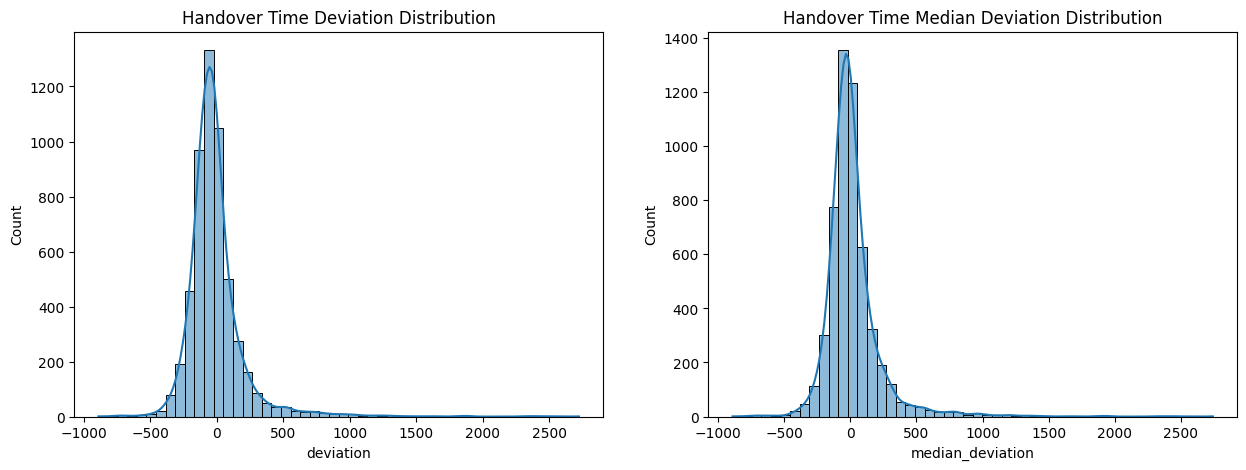

In [57]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(test_data['deviation'], bins=50, kde=True)
plt.title('Handover Time Deviation Distribution')
plt.subplot(1, 2, 2)
sns.histplot(test_data['median_deviation'], bins=50, kde=True)
plt.title('Handover Time Median Deviation Distribution')
plt.show()

In [58]:
print(f'orders bettwr than average: {test_data['better_than_avg'].mean()*100}%')
print(f'orders bettwr than median: {test_data['better_than_median'].mean()*100}%')

orders bettwr than average: 35.08999814436816%
orders bettwr than median: 43.57023566524402%


In [59]:
print(f'Handover time improvement on average: {test_data[test_data['better_than_avg']]['deviation'].mean().__round__()} seconds')

Handover time improvement on average: 175 seconds


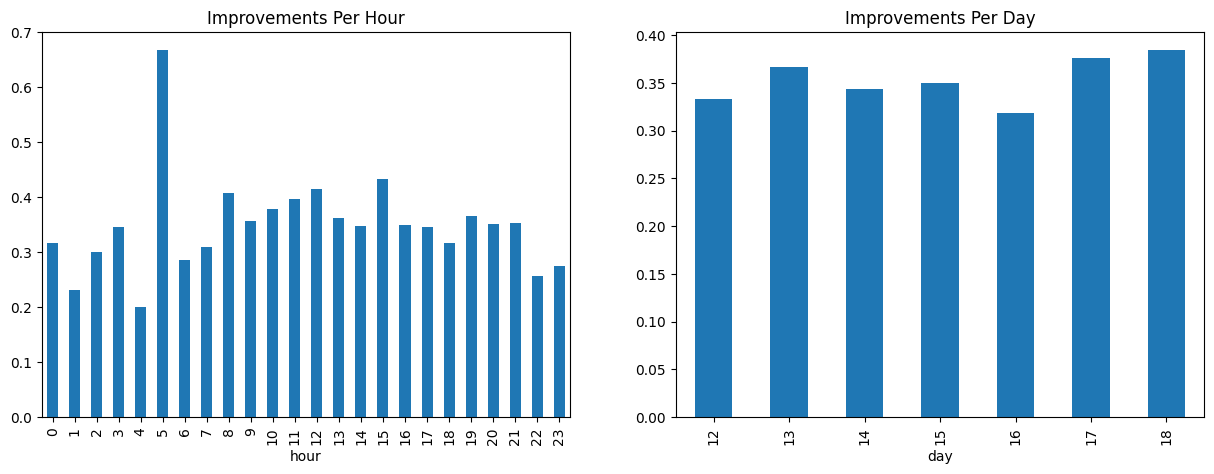

In [60]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
test_data.groupby('hour')['better_than_avg'].mean().plot(kind='bar')
plt.title('Improvements Per Hour')
plt.subplot(1, 2, 2)
test_data.groupby('day')['better_than_avg'].mean().plot(kind='bar')
plt.title('Improvements Per Day')
plt.show()

In [61]:
all_fleets = test_data['fleets'].str.split(',').explode().str.strip()
unique_fleets = all_fleets.unique().tolist()
print(len(unique_fleets))
print(unique_fleets)


9
['SF_Downtown', 'QS_Businessbay', 'Businessbay', 'QS_Exectower', 'Karama', 'Marina', 'Alqouz', 'Motorcity', 'nn_QS_Alquoz']


In [63]:
test_data_by_fleets = test_data.copy()
test_data_by_fleets['fleets'] = test_data_by_fleets['fleets'].str.split(',')
test_data_by_fleets = test_data_by_fleets.explode('fleets')
test_data_by_fleets['fleets'] = test_data_by_fleets['fleets'].str.strip()

test_data_by_fleets.groupby('fleets')['better_than_avg'].mean().sort_values(ascending=False)

fleets
Motorcity         0.583333
QS_Businessbay    0.446429
QS_Exectower      0.397403
Alqouz            0.367816
SF_Downtown       0.350900
Businessbay       0.350309
Karama            0.348133
Marina            0.300000
nn_QS_Alquoz      0.000000
Name: better_than_avg, dtype: float64

In [64]:
print('count of orders per fleet along witht the improvement rate: ')
test_data_by_fleets.groupby('fleets')['better_than_avg'].agg(['count', 'mean']).sort_values(by='mean', ascending=False)

count of orders per fleet along witht the improvement rate: 


,count,mean
fleets,,
Motorcity,12,0.583333
QS_Businessbay,56,0.446429
QS_Exectower,385,0.397403
Alqouz,174,0.367816
SF_Downtown,5389,0.350900
Businessbay,4202,0.350309
Karama,991,0.348133
Marina,10,0.300000
nn_QS_Alquoz,1,0.000000


In [65]:
print('Improvement per location:')
test_data.groupby(['p_lat', 'p_lng'])['better_than_avg'].mean().sort_values(ascending=False)

Improvement per location:


p_lat      p_lng    
25.202153  55.272572    1.00
25.173140  55.237988    1.00
25.176569  55.245090    1.00
25.180101  55.246638    1.00
25.106719  55.241124    0.75
                        ... 
25.185868  55.264152    0.00
25.192923  55.288791    0.00
25.169657  55.260363    0.00
25.203874  55.277410    0.00
25.207665  55.251805    0.00
Name: better_than_avg, Length: 257, dtype: float64

In [66]:
print("Number of addresses per improvement:")
test_data.groupby('dst_address_code')['better_than_avg'].mean().value_counts()
#test_data.groupby('dst_address_code')['better_than_avg'].agg(['count', 'mean']).sort_values(by='mean', ascending=False).value_counts()

Number of addresses per improvement:


better_than_avg
0.000000    1075
1.000000     461
0.500000     278
0.333333     157
0.666667      76
0.250000      72
0.400000      35
0.750000      31
0.200000      27
0.600000      17
0.166667      14
0.142857      12
0.800000       9
0.375000       9
0.285714       8
0.714286       6
0.571429       4
0.428571       3
0.222222       3
0.363636       3
0.100000       2
0.111111       1
0.187500       1
0.125000       1
0.181818       1
0.636364       1
0.833333       1
0.625000       1
0.555556       1
0.384615       1
0.615385       1
Name: count, dtype: int64

In [67]:
# get the top 50 dst_address_code with the most improvements and see if they could be clustered together based on their lat and lng
# need to set a radius for the clustering
# re check AQ's doc
test_data.groupby('dst_address_code')['better_than_avg'].mean().sort_values(ascending=False).head(461)

dst_address_code
addr::noon_customer::ae::00c20c6b0b1ce91a7b7b8dd519969a8e::1    1.0
addr::noon_customer::ae::fea4163c344a73d146d023e3c1d13396::3    1.0
addr::noon_customer::ae::fe8ecb92f48d9543e88840c824196f16::4    1.0
addr::noon_customer::ae::7aa316126194d925839c4d1ee1d4efb5::2    1.0
addr::noon_customer::ae::76b93015b171d95dffb806febd8f859d::3    1.0
                                                               ... 
addr::noon_customer::ae::03804414d5995bddf66185fa21fa1c70::1    1.0
addr::noon_customer::ae::ff3beb5fa87d3fd1e45719abf2fd936c::3    1.0
addr::noon_customer::ae::fef0f085f80a1871b1ab956c2e979902::4    1.0
addr::noon_customer::ae::fee198dc9842e537c16fa7ca0c2010ba::2    1.0
addr::noon_customer::ae::01d52db8e6fd18b2cee98ae71e1d498f::3    1.0
Name: better_than_avg, Length: 461, dtype: float64

# Discuss

In [ ]:
# avg in tasks != avg in addresses nor median in addresses
tasks_1000 = pd.read_csv('task_1000_data.csv', index_col=0)
addresses = pd.read_csv('address_data.csv', index_col=0)
test_data = tasks_1000.join(addresses, on='dst_address_code', how='inner', lsuffix='_tasks', rsuffix='_addresses')
print((test_data['avg_handover_last_3_months_tasks'] == test_data['avg_handover_last_3_months_addresses']).value_counts())
print((test_data['avg_handover_last_3_months_tasks'] == test_data['median_handover_last_3_months']).value_counts())
test_data[test_data['avg_handover_last_3_months_tasks'] != test_data['avg_handover_last_3_months_addresses']]

False    971
True      64
Name: count, dtype: int64
False    1035
Name: count, dtype: int64


,created_at,mp_Task_nr,handover_time_seconds,o2a_time_seconds,p2a_time_seconds,phone_calls,dst_address_code,fleets,reasons,p_lat_tasks,...,why,is_parking_accurate,time_in_dubai,hour,day,is_weekend,p_lat_addresses,p_lng_addresses,avg_handover_last_3_months_addresses,median_handover_last_3_months
id_task,,,,,,,,,,,,,,,,,,,,,
60170297.0,2025-03-13 12:38:15.000000 UTC,NNF3DNN3FSELWJYA,406.0,2566.0,1785.0,3.0,addr::noon_customer::ae::80fa2c3ebc879d6f0bcd6...,"QS_Exectower,SF_Downtown,Businessbay","forgot_to_mark_delivered,forgot_to_mark_delive...",25.190008,...,NaN,NaN,2025-03-13 16:38,16.0,13.0,False,25.190008,55.263444,340.750000,269.0
60200190.0,2025-03-13 16:28:04.000000 UTC,FF3DNN3RA6KIRQA,110.0,2433.0,1370.0,0.0,addr::noon_customer::ae::b7db816ba226a8e662d24...,"Businessbay,SF_Downtown",NaN,25.176937,...,NaN,NaN,2025-03-13 20:28,20.0,13.0,False,25.176937,55.270768,150.965517,145.0
60200801.0,2025-03-13 16:34:11.000000 UTC,FF3DNN6V8034ZPA,65.0,2274.0,687.0,0.0,addr::noon_customer::ae::590b570c48f7eb264f683...,"Businessbay,SF_Downtown",NaN,25.180026,...,NaN,NaN,2025-03-13 20:34,20.0,13.0,False,25.180026,55.265976,170.518518,154.0
60144702.0,2025-03-13 04:58:44.000000 UTC,FF3DNNW6JTZX55A,171.0,2105.0,1232.0,0.0,addr::noon_customer::ae::86974a8440f1bf8c3b209...,"Businessbay,SF_Downtown",NaN,25.175128,...,NaN,NaN,2025-03-13 8:58,8.0,13.0,False,25.175128,55.309065,227.294118,225.0
60191382.0,2025-03-13 15:08:44.000000 UTC,FF3DNNPNZZCVROA,452.0,2129.0,1441.0,2.0,addr::noon_customer::ae::ae79e0ab559002cf3f812...,"Businessbay,SF_Downtown","entry_not_allowed,entry_not_allowed",25.190447,...,NaN,NaN,2025-03-13 19:8,19.0,13.0,False,25.190447,55.281143,255.086957,211.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60154481.0,2025-03-13 08:52:58.000000 UTC,FF3DNNGV4D2F1PA,386.0,1991.0,822.0,2.0,addr::noon_customer::ae::fae9358ca361401e9b0cc...,"SF_Downtown,Businessbay","entry_not_allowed,entry_not_allowed",25.187555,...,NaN,NaN,NaN,NaN,NaN,NaN,25.187555,55.261026,486.900000,390.0
60158335.0,2025-03-13 09:50:01.000000 UTC,FF3DNNYR5TYN1DA,289.0,3344.0,1117.0,0.0,addr::noon_customer::ae::f199047353ac8adab4313...,"SF_Downtown,Karama",NaN,25.202900,...,NaN,NaN,NaN,NaN,NaN,NaN,25.202900,55.281388,429.700000,409.5
60209340.0,2025-03-13 17:57:10.000000 UTC,FF3DNN06D1B653A,525.0,2272.0,1334.0,2.0,addr::noon_customer::ae::f3dff9fce5f841ee45634...,"Businessbay,SF_Downtown","entry_not_allowed,entry_not_allowed",25.188730,...,NaN,NaN,NaN,NaN,NaN,NaN,25.188730,55.260381,352.181818,267.0


# misc

In [ ]:
test_data.drop(columns=['avg_address_handover_last_3_months_addresses'], inplace=True)
test_data.rename(columns={'avg_address_handover_last_3_months_tasks': 'avg_address_handover_last_3_months'}, inplace=True)
test_data

In [39]:
(test_data['median_address_handover_last3months'] == test_data['median_handover_last_3_months']).value_counts()

True    5418
Name: count, dtype: int64

In [40]:
test_data.drop(columns=['median_handover_last_3_months'], inplace=True)

In [41]:
test_data['median_deviation'] = test_data['handover_time_seconds'] - test_data['median_address_handover_last3months']
(test_data['median_deviation'] == test_data['temp_median_deviation']).value_counts()

False    5401
True       17
Name: count, dtype: int64